<a href="https://colab.research.google.com/github/biglool/Hologram_Cell_detection/blob/main/notebooks/test%20rcnn/RPN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import keras
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tq

from tensorflow.keras.utils import Sequence


from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

import tensorflow as tf
from PIL import Image
import zipfile


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Curro/Hologrames/Datos_sinteticos/Holo_subdiv/sub/1000_muestras_completas_small_count'

/content/gdrive/MyDrive/Curro/Hologrames/Datos_sinteticos/Holo_subdiv/sub/1000_muestras_completas_small_count


FasterRcnn de pytorch

In [ ]:
def non_max_suppression(boxes, scores, max_boxes=50, iou_threshold=0.5):
    idxs = np.argsort(scores)[::-1]
    selected_idxs = []

    while len(idxs) > 0:
        selected_idx = idxs[0]
        selected_idxs.append(selected_idx)
        if len(selected_idxs) >= max_boxes:
            break

        idxs = idxs[1:]
        filtered_idxs = []

        for idx in idxs:
            iou = calculate_iou(boxes[selected_idx], boxes[idx])
            if iou < iou_threshold:
                filtered_idxs.append(idx)

        idxs = filtered_idxs

    return selected_idxs

In [ ]:
'''
implementaciones otras loses para keras
'''


@tf.keras.utils.register_keras_serializable()
def dice_coef_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Register the custom loss function
get_custom_objects().update({"dice_coef_loss": dice_coef_loss})


@tf.keras.utils.register_keras_serializable()
def tversky_loss(y_true, y_pred, alpha=0.5, beta=2):
    # Convert predictions to probabilities
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    # Calculate true positives (TP), false positives (FP), and false negatives (FN)
    tp = K.sum(y_true * y_pred, axis=-1)
    fp = K.sum((1 - y_true) * y_pred, axis=-1)
    fn = K.sum(y_true * (1 - y_pred), axis=-1)

    # Calculate the Tversky index
    tversky_index = (tp + K.epsilon()) / (tp + alpha * fp + beta * fn + K.epsilon())

    # Return the Tversky loss
    return 1 - tversky_index
get_custom_objects().update({"tversky_loss": tversky_loss})


@tf.keras.utils.register_keras_serializable()
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1,2,3])
    iou = (intersection + smooth) / (sum_ - intersection + smooth)
    return iou
get_custom_objects().update({"iou": iou})

@tf.keras.utils.register_keras_serializable()
def jaccard_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return 1 - (intersection + 1) / (union + 1)
get_custom_objects().update({"jaccard_loss": jaccard_loss})

@tf.keras.utils.register_keras_serializable()
def pixel_accuracy(y_true, y_pred):
    y_pred = K.round(y_pred)
    correct_pixels = K.sum(K.cast(K.equal(y_true, y_pred), K.floatx()))
    total_pixels = K.cast(K.prod(K.shape(y_true)), K.floatx())
    return (correct_pixels / total_pixels)
get_custom_objects().update({"pixel_accuracy": pixel_accuracy})


@tf.keras.utils.register_keras_serializable()
def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(tf.round(y_pred), tf.int32)

    # True Negatives
    tn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 0)), tf.float32))

    # False Positives
    fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 1)), tf.float32))

    specificity = tn / (tn + fp + K.epsilon())
    return specificity
get_custom_objects().update({"specificity": specificity})

@tf.keras.utils.register_keras_serializable()
def focal_loss(y_true, y_pred):
        gamma=2.,
        alpha=0.25
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

        # Clip the prediction values to prevent NaNs
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Compute cross-entropy loss
        cross_entropy = -y_true * K.log(y_pred)

        # Compute weight
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)

        # Compute Focal Loss
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)

get_custom_objects().update({"focal_loss": focal_loss})

@tf.keras.utils.register_keras_serializable()
def combined_loss(y_true, y_pred):
    # Binary cross-entropy loss
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

    # Dice loss
    dice = 1 - (2 * tf.reduce_sum(y_true * y_pred) + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

    return bce + dice

In [ ]:
def generate_all_anchors(image_size, grid_size, base_size, ratios, scales):
    """
    Generate all anchors for an entire grid on an image.
    Args:
    - image_size: (width, height) of the image
    - grid_size: size of the grid (n_tiles_x, n_tiles_y)
    - base_size: size of each tile (width and height)
    - ratios: list of aspect ratios
    - scales: list of scales
    Returns:
    - all_anchors: dictionary with tile indices as keys and list of anchors as values
    """
    all_anchors = []#{}
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            center_x = i * base_size + base_size / 2
            center_y = j * base_size + base_size / 2
            anchors = generate_anchors_for_tile((center_x, center_y), base_size, ratios, scales, image_size)
            #anchors=np.array(anchors).reshape(len(scales)*len(ratios),4)
            #all_anchors[(i, j)] = anchors
            for anchor in anchors: all_anchors.append(anchor)

    return np.array(all_anchors)

def generate_anchors_for_tile(center, base_size, ratios, scales, image_size):
    """
    Generate anchor boxes centered on a specific point in the tile with boundary checks.
    """
    anchors = []
    for scale in scales:
        for ratio in ratios:
            w = base_size * scale * np.sqrt(ratio)
            h = base_size * scale / np.sqrt(ratio)
            x1 = center[0] - w / 2
            y1 = center[1] - h / 2
            x2 = center[0] + w / 2
            y2 = center[1] + h / 2
            x1, x2 = max(0, x1), min(image_size[0], x2)
            y1, y2 = max(0, y1), min(image_size[1], y2)
            anchors.append([x1, y1, x2, y2])
    return anchors

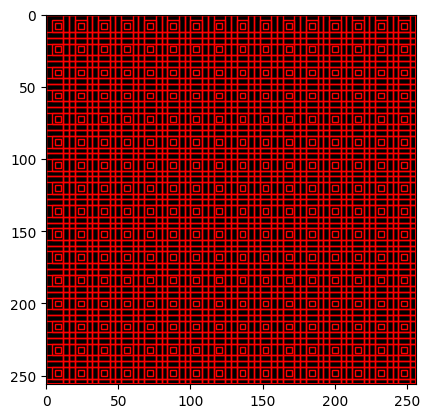

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_anchors_on_image(image_size, all_anchors):
    """
    Plot all anchors on an image.
    """
    fig, ax = plt.subplots(1)
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(0, image_size[1])
    ax.set_aspect('equal')
    ax.imshow(np.zeros(image_size), extent=(0, image_size[0], 0, image_size[1]), cmap='gray')

    for (x1, y1, x2, y2) in all_anchors:
        #for (x1, y1, x2, y2) in anchors:
        ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none'))

    plt.gca().invert_yaxis()  # Invert Y axis to match image coordinate system
    plt.show()

# Configuration
image_size = (256, 256)
grid_size = (32, 32)
tile_size = 16
ratios = [1]  # Aspect ratios
scales = [ (1/4),(1/2),1,1.5]   # Scales based on the constraint

# Generate all anchors
all_anchors = generate_all_anchors(image_size, grid_size, tile_size, ratios, scales)

# Plot the anchors
plot_anchors_on_image(image_size, all_anchors)

In [ ]:
import numpy as np



def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    return intersection / union

def get_rpn_targets(anchors, gt_boxes, img_shape, pos_iou_thresh=0.5, neg_iou_thresh=0.5):
    num_anchors = anchors.shape[0]
    y_rpn_cls = np.zeros((num_anchors, 1), dtype=np.float32)
    y_rpn_regr = np.zeros((num_anchors, 4), dtype=np.float32)
    y_rpn_regr_unscaled = np.zeros((num_anchors, 4), dtype=np.float32)

    for gt_box in gt_boxes:
        best_iou = 0
        best_anchor_idx = -1

        for i in range(num_anchors):
            anchor = anchors[i]
            iou = calculate_iou(anchor, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_anchor_idx = i
                print(best_iou)


            if iou >= pos_iou_thresh:
                y_rpn_cls[i] = 1
                cx = (anchor[0] + anchor[2]) / 2
                cy = (anchor[1] + anchor[3]) / 2
                w = anchor[2] - anchor[0]
                h = anchor[3] - anchor[1]

                gt_cx = (gt_box[0] + gt_box[2]) / 2
                gt_cy = (gt_box[1] + gt_box[3]) / 2
                gt_w = gt_box[2] - gt_box[0]
                gt_h = gt_box[3] - gt_box[1]

                y_rpn_regr_unscaled[i, 0] = (gt_cx - cx) / w
                y_rpn_regr_unscaled[i, 1] = (gt_cy - cy) / h
                y_rpn_regr_unscaled[i, 2] = np.log(gt_w / w)
                y_rpn_regr_unscaled[i, 3] = np.log(gt_h / h)

        # Force assign the best anchor as positive if no anchors have sufficient IoU
        if best_iou < pos_iou_thresh:
            y_rpn_cls[best_anchor_idx] = 1
            anchor = anchors[best_anchor_idx]
            cx = (anchor[0] + anchor[2]) / 2
            cy = (anchor[1] + anchor[3]) / 2
            w = anchor[2] - anchor[0]
            h = anchor[3] - anchor[1]

            gt_cx = (gt_box[0] + gt_box[2]) / 2
            gt_cy = (gt_box[1] + gt_box[3]) / 2
            gt_w = gt_box[2] - gt_box[0]
            gt_h = gt_box[3] - gt_box[1]

            y_rpn_regr_unscaled[best_anchor_idx, 0] = (gt_cx - cx) / w
            y_rpn_regr_unscaled[best_anchor_idx, 1] = (gt_cy - cy) / h
            y_rpn_regr_unscaled[best_anchor_idx, 2] = np.log(gt_w / w)
            y_rpn_regr_unscaled[best_anchor_idx, 3] = np.log(gt_h / h)

    y_rpn_regr[:, 0] = y_rpn_regr_unscaled[:, 0] * 10.0
    y_rpn_regr[:, 1] = y_rpn_regr_unscaled[:, 1] * 10.0
    y_rpn_regr[:, 2] = y_rpn_regr_unscaled[:, 2] * 5.0
    y_rpn_regr[:, 3] = y_rpn_regr_unscaled[:, 3] * 5.0

    return y_rpn_cls, y_rpn_regr

# Example usage
# Configuration
image_size = (256, 256)
feature_map_shape = (32, 32)
tile_size = 16
ratios = [1]  # Aspect ratios
scales = [ (1/4),(1/2),1,1.5]  # Scales based on the constraint

# Generate all anchors
anchors = generate_all_anchors(image_size, feature_map_shape, tile_size, ratios, scales)

print(f"Total number of anchors: {anchors.shape[0]}")  # Should be 9216

# Example ground truth boxes
gt_boxes = np.array([[5, 5, 8, 8]])

#

# Generate RPN targets
y_rpn_cls, y_rpn_regr = get_rpn_targets(anchors, gt_boxes, image_size)
print(f"Shape of y_rpn_cls: {y_rpn_cls.shape}")  # Should be (9216, 1)
print(f"Shape of y_rpn_regr: {y_rpn_regr.shape}")  # Should be (9216, 4)

Total number of anchors: 4096
0.19047619047619047
Shape of y_rpn_cls: (4096, 1)
Shape of y_rpn_regr: (4096, 4)


In [ ]:
import pickle
import os
import pickle
import numpy as np
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data_folder, ground_truth_folder, batch_size, img_shape, anchors, shuffle=True, max_examples=0):
        self.data_folder = data_folder
        self.ground_truth_folder = ground_truth_folder
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.anchors = anchors  # Anchors generated beforehand
        self.shuffle = shuffle
        self.data_files = sorted([f for f in os.listdir(data_folder)])
        self.ground_truth_files = sorted([f for f in os.listdir(ground_truth_folder)])
        self.indexes = np.arange(len(self.data_files))
        self.max_examples = max_examples
        self.on_epoch_end()

    def __len__(self):
        if self.max_examples == 0:
            num_examples = len(self.data_files)
        else:
            num_examples = min(self.max_examples, len(self.data_files))
        return int(np.floor(num_examples / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data_files = [self.data_files[k] for k in batch_indexes]
        batch_ground_truth_files = [self.ground_truth_files[k] for k in batch_indexes]

        X, y_rpn_cls, y_rpn_regr = self.__data_generation(batch_data_files, batch_ground_truth_files)

        return X, [y_rpn_cls, y_rpn_regr]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def scale_array(self, array):
        min_val = np.min(array)
        max_val = np.max(array)
        scaled_array = 2 * (array - min_val) / (max_val - min_val) - 1
        return scaled_array

    def __data_generation(self, batch_data_files, batch_ground_truth_files):
        X = np.empty((self.batch_size, *self.img_shape), dtype='float32')
        y_rpn_cls = np.zeros((self.batch_size, self.anchors.shape[0], 1), dtype='float32')  # Adjust dimensions as per your RPN output
        y_rpn_regr = np.zeros((self.batch_size, self.anchors.shape[0], 4), dtype='float32')  # Adjust dimensions as per your RPN output

        for i, (data_file, gt_file) in enumerate(zip(batch_data_files, batch_ground_truth_files)):
            data_array = np.loadtxt(os.path.join(self.data_folder, data_file))
            data_array = self.scale_array(data_array)
            data_array = data_array.reshape(self.img_shape)

            with open(os.path.join(self.ground_truth_folder, gt_file), 'rb') as f:
                ground_truth_list = pickle.load(f)
                processed_ground_truth = []
                for obj in ground_truth_list:
                    rad = obj[3]
                    x1 = obj[0] - rad
                    y1 = obj[1] - rad
                    x2 = obj[0] + rad
                    y2 = obj[1] + rad
                    processed_ground_truth.append([x1, y1, x2, y2])

            X[i,] = data_array

            # Use pre-generated anchors for RPN targets
            y_rpn_cls[i], y_rpn_regr[i] = get_rpn_targets(self.anchors, np.array(processed_ground_truth), self.img_shape)

        return X, y_rpn_cls, y_rpn_regr


# Example usage
data_folder = 'mascaras'  # Modify as per your directory structure
ground_truth_folder = 'parametros'  # Modify as per your directory structure
img_shape = (256, 256, 1)
batch_size = 16

# Example anchors (generate these beforehand)
anchors = generate_all_anchors(image_size=img_shape, grid_size=(32, 32), base_size=16, ratios=[1], scales=[0.25, 0.5, 1.0, 1.5])

# Create data generators for training, validation, and test sets
train_gen = DataGenerator(data_folder+"/train/", ground_truth_folder+"/train/", batch_size, img_shape, anchors, shuffle=True)
val_gen = DataGenerator(data_folder+"/val/", ground_truth_folder+"/val/", batch_size, img_shape, anchors, shuffle=False)
test_gen = DataGenerator(data_folder+"/test/", ground_truth_folder+"/test/", batch_size, img_shape, anchors, shuffle=False)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, Reshape
from tensorflow.keras.models import Model
from keras.models import load_model

def rpn_model(image_shape, num_anchors):
    inputs = Input(shape=image_shape, name='input_image')


    # Load the pre-trained model
    pretrain_model = load_model('Basic.keras')
    # Use the 5 conv netwoerk as output
    output = pretrain_model.layers[-8].output

    # Create a new model with the desired output
    rebuild_model = Model(inputs=pretrain_model.input, outputs=output)

    # Print the summary of the new model
    #for layer in rebuild_model.layers:
        #layer.trainable = False

    x = rebuild_model.output

    # RPN classification layer
    rpn_cls = Conv2D(num_anchors * 1, (1, 1), activation='linear', name='rpn_cls')(x)
    rpn_cls = Activation('sigmoid', name='rpn_cls_sigmoid')(rpn_cls)
    rpn_cls = Reshape((-1, 1), name='rpn_cls_reshape')(rpn_cls)

    # RPN regression layer
    rpn_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', name='rpn_regr')(x)
    rpn_regr = Reshape((-1, 4), name='rpn_regr_reshape')(rpn_regr)

    model = Model(inputs=rebuild_model.input, outputs=[rpn_cls, rpn_regr], name='rpn_model')

    return model

# Example usage
image_shape = (256, 256, 1)  # Example image shape (height, width, channels)
num_anchors = 4  # Number of anchors per feature map location (depending on ratios and scales)

# Create RPN model
rpn_model = rpn_model(image_shape, num_anchors)

# Compile RPN model
rpn_model.compile(optimizer='adam', loss={'rpn_cls_reshape': 'binary_crossentropy', 'rpn_regr_reshape': 'mse'})

# Print model summary
rpn_model.summary()

Model: "rpn_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['max_pooling2d[0][0]'

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_rpn_model2.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Compile RPN model
rpn_model.compile(optimizer='adam', loss={'rpn_cls_reshape': 'binary_crossentropy', 'rpn_regr_reshape': 'mse'})

# Fit model with training and validation data, including callbacks
rpn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[early_stopping, checkpoint]
)


# Save final trained model
rpn_model.save('final_rpn_model2.keras')

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.0832 - rpn_cls_reshape_loss: 0.0466 - rpn_regr_reshape_loss: 0.0174
Epoch 1: val_loss improved from inf to 0.02327, saving model to best_rpn_model.keras
300/300 [==============================] - 489s 2s/step - loss: 0.0832 - rpn_cls_reshape_loss: 0.0466 - rpn_regr_reshape_loss: 0.0174 - val_loss: 0.0233 - val_rpn_cls_reshape_loss: 0.0075 - val_rpn_regr_reshape_loss: 0.0046
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.0208 - rpn_cls_reshape_loss: 0.0070 - rpn_regr_reshape_loss: 0.0046
Epoch 2: val_loss improved from 0.02327 to 0.01920, saving model to best_rpn_model.keras
300/300 [==============================] - 485s 2s/step - loss: 0.0208 - rpn_cls_reshape_loss: 0.0070 - rpn_regr_reshape_loss: 0.0046 - val_loss: 0.0192 - val_rpn_cls_reshape_loss: 0.0070 - val_rpn_regr_reshape_loss: 0.0046
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.0178 - rpn_cls_reshape_

In [ ]:
for i,val in enumerate(val_gen.__getitem__(0)):


In [ ]:
from keras.models import load_model
pretrain_rpn_model = load_model('best_rpn_model.keras')

results=pretrain_rpn_model.predict(val_gen.__getitem__(0)[0])
cls_res=results[0][0]
reg_res=results[1][0]
print(cls_res)
print(reg_res)
for i,val in enumerate(val_gen.__getitem__(0)[1][0][0]):
  if val==1:
    print(cls_res[i])
    print(reg_res[i])
    print(val_gen.__getitem__(0)[1][1][0][i])



1/1 [==============================] - 2s 2s/step
[[1.5208215e-06]
 [6.2999585e-05]
 [1.0081759e-03]
 ...
 [6.4024214e-05]
 [1.0199103e-03]
 [2.5098474e-04]]
[[-5.9943274e-04  1.9880291e-03  2.7971528e-04 -8.1455521e-04]
 [ 1.5314892e-03 -9.5396116e-04 -3.2892134e-03  3.5421681e-03]
 [ 9.8318979e-04  2.7908050e-03  2.3118546e-04 -9.6072443e-04]
 ...
 [ 1.2879446e-03 -9.5357001e-04 -2.9740464e-03  3.2615280e-03]
 [ 1.2342632e-03  2.3065470e-03  5.6078658e-05 -1.2341440e-03]
 [-6.5822015e-04  2.7367277e-03  2.9293764e-03 -6.8039447e-04]]
[0.00064144]
[-0.0015523   0.00225445 -0.00076039 -0.00017583]
[ 2.5       -2.5       -3.9007928 -3.9007928]
[0.00221145]
[ 0.00032534  0.00221977 -0.00350276 -0.00272693]
[ 1.25       4.84375   -2.3500183 -2.3500183]
[0.00221145]
[ 0.00032534  0.00221977 -0.00350276 -0.00272693]
[-2.1875    -3.75      -1.4384104 -1.4384104]


In [ ]:
!git clone https://github.com/kbardool/keras-frcnn.git

Cloning into 'keras-frcnn'...
remote: Enumerating objects: 635, done.
remote: Total 635 (delta 0), reused 0 (delta 0), pack-reused 635
Receiving objects: 100% (635/635), 187.79 KiB | 1.46 MiB/s, done.
Resolving deltas: 100% (433/433), done.
